<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9c909a298a51f6d178e9401c5042dfae4884d8371635b2e90a4ec5df3118f5c7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c65216a47e4db1f3a1c13c5a537b17ba05f1ab8ce7cf6de686791da4e14841c4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:02<00:00, 57.0MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [5]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [8]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 100
    batch_size = 16
    learning_rate = 5e-4
    momentum = 0.9
    weight_decay = 1e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [9]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [10]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [12]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.6MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
model = model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

#6. Training and testing

In [13]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 40:
        return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        return self.weight_bce * bce_loss + self.weight_dice * dice_loss
# BCE + DICE
criterion = CombinedLoss(weight_bce=0.1, weight_dice=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [14]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    #scheduler.step()

    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch 1/100, Training Loss: 0.6630


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 1/100, Validation Loss: 0.6819
Precision: 0.3733, Recall: 0.4374, Accuracy: 0.5848
IoU: 0.2485, F1 Score: 0.4028, Dice Coefficient: 0.3963
Pixel Error: 0.4152, Rand Error: 0.9786


Epoch 2/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 2/100, Training Loss: 0.6561


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 2/100, Validation Loss: 0.6704
Precision: 0.3521, Recall: 0.5250, Accuracy: 0.5386
IoU: 0.2631, F1 Score: 0.4215, Dice Coefficient: 0.4143
Pixel Error: 0.4614, Rand Error: 0.9937


Epoch 3/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch 3/100, Training Loss: 0.6459


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 3/100, Validation Loss: 0.6658
Precision: 0.3750, Recall: 0.6178, Accuracy: 0.5480
IoU: 0.3011, F1 Score: 0.4667, Dice Coefficient: 0.4606
Pixel Error: 0.4520, Rand Error: 0.9859


Epoch 4/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]


Epoch 4/100, Training Loss: 0.6331


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 4/100, Validation Loss: 0.6599
Precision: 0.3599, Recall: 0.5355, Accuracy: 0.5463
IoU: 0.2696, F1 Score: 0.4304, Dice Coefficient: 0.4219
Pixel Error: 0.4537, Rand Error: 0.9909


Epoch 5/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch 5/100, Training Loss: 0.6200


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 5/100, Validation Loss: 0.6375
Precision: 0.4017, Recall: 0.5403, Accuracy: 0.5952
IoU: 0.2957, F1 Score: 0.4608, Dice Coefficient: 0.4548
Pixel Error: 0.4048, Rand Error: 0.9656


Epoch 6/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 6/100, Training Loss: 0.6027


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 6/100, Validation Loss: 0.6304
Precision: 0.3862, Recall: 0.5717, Accuracy: 0.5720
IoU: 0.2970, F1 Score: 0.4610, Dice Coefficient: 0.4576
Pixel Error: 0.4280, Rand Error: 0.9733


Epoch 7/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch 7/100, Training Loss: 0.5831


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 7/100, Validation Loss: 0.5792
Precision: 0.4857, Recall: 0.5934, Accuracy: 0.6687
IoU: 0.3597, F1 Score: 0.5341, Dice Coefficient: 0.5275
Pixel Error: 0.3313, Rand Error: 0.8913


Epoch 8/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch 8/100, Training Loss: 0.5494


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Epoch 8/100, Validation Loss: 0.5737
Precision: 0.4897, Recall: 0.5998, Accuracy: 0.6718
IoU: 0.3602, F1 Score: 0.5392, Dice Coefficient: 0.5264
Pixel Error: 0.3282, Rand Error: 0.8913


Epoch 9/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch 9/100, Training Loss: 0.5195


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 9/100, Validation Loss: 0.5082
Precision: 0.5591, Recall: 0.6202, Accuracy: 0.7218
IoU: 0.4101, F1 Score: 0.5881, Dice Coefficient: 0.5785
Pixel Error: 0.2782, Rand Error: 0.8118


Epoch 10/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 10/100, Training Loss: 0.4796


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 10/100, Validation Loss: 0.4546
Precision: 0.6424, Recall: 0.7164, Accuracy: 0.7815
IoU: 0.5042, F1 Score: 0.6774, Dice Coefficient: 0.6660
Pixel Error: 0.2185, Rand Error: 0.6897


Epoch 11/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch 11/100, Training Loss: 0.4298


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 11/100, Validation Loss: 0.4307
Precision: 0.6026, Recall: 0.7843, Accuracy: 0.7654
IoU: 0.5131, F1 Score: 0.6816, Dice Coefficient: 0.6732
Pixel Error: 0.2346, Rand Error: 0.7115


Epoch 12/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch 12/100, Training Loss: 0.4189


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 12/100, Validation Loss: 0.4165
Precision: 0.6398, Recall: 0.7322, Accuracy: 0.7823
IoU: 0.5123, F1 Score: 0.6829, Dice Coefficient: 0.6748
Pixel Error: 0.2177, Rand Error: 0.6862


Epoch 13/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch 13/100, Training Loss: 0.4077


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 13/100, Validation Loss: 0.4328
Precision: 0.7154, Recall: 0.6104, Accuracy: 0.7975
IoU: 0.4883, F1 Score: 0.6587, Dice Coefficient: 0.6556
Pixel Error: 0.2025, Rand Error: 0.6633


Epoch 14/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 14/100, Training Loss: 0.3966


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 14/100, Validation Loss: 0.5349
Precision: 0.4297, Recall: 0.8242, Accuracy: 0.5935
IoU: 0.3889, F1 Score: 0.5649, Dice Coefficient: 0.5558
Pixel Error: 0.4065, Rand Error: 0.9586


Epoch 15/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch 15/100, Training Loss: 0.4234


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 15/100, Validation Loss: 0.4274
Precision: 0.5606, Recall: 0.8625, Accuracy: 0.7395
IoU: 0.5103, F1 Score: 0.6795, Dice Coefficient: 0.6714
Pixel Error: 0.2605, Rand Error: 0.7608


Epoch 16/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch 16/100, Training Loss: 0.4064


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 16/100, Validation Loss: 0.4112
Precision: 0.7006, Recall: 0.6625, Accuracy: 0.8013
IoU: 0.5102, F1 Score: 0.6810, Dice Coefficient: 0.6736
Pixel Error: 0.1987, Rand Error: 0.6506


Epoch 17/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch 17/100, Training Loss: 0.3916


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 17/100, Validation Loss: 0.3881
Precision: 0.6296, Recall: 0.7945, Accuracy: 0.7846
IoU: 0.5386, F1 Score: 0.7025, Dice Coefficient: 0.6977
Pixel Error: 0.2154, Rand Error: 0.6739


Epoch 18/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 18/100, Training Loss: 0.3615


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 18/100, Validation Loss: 0.3777
Precision: 0.6166, Recall: 0.8455, Accuracy: 0.7822
IoU: 0.5512, F1 Score: 0.7131, Dice Coefficient: 0.7081
Pixel Error: 0.2178, Rand Error: 0.6774


Epoch 19/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


Epoch 19/100, Training Loss: 0.3602


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Epoch 19/100, Validation Loss: 0.3699
Precision: 0.6439, Recall: 0.8181, Accuracy: 0.7969
IoU: 0.5604, F1 Score: 0.7206, Dice Coefficient: 0.7163
Pixel Error: 0.2031, Rand Error: 0.6457


Epoch 20/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 20/100, Training Loss: 0.3532


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 20/100, Validation Loss: 0.4180
Precision: 0.6085, Recall: 0.7673, Accuracy: 0.7675
IoU: 0.5050, F1 Score: 0.6787, Dice Coefficient: 0.6678
Pixel Error: 0.2325, Rand Error: 0.7179


Epoch 21/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 21/100, Training Loss: 0.3696


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 21/100, Validation Loss: 0.3710
Precision: 0.6873, Recall: 0.7385, Accuracy: 0.8087
IoU: 0.5502, F1 Score: 0.7120, Dice Coefficient: 0.7081
Pixel Error: 0.1913, Rand Error: 0.6236


Epoch 22/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 22/100, Training Loss: 0.3450


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 22/100, Validation Loss: 0.3552
Precision: 0.6718, Recall: 0.7941, Accuracy: 0.8099
IoU: 0.5690, F1 Score: 0.7278, Dice Coefficient: 0.7235
Pixel Error: 0.1901, Rand Error: 0.6169


Epoch 23/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 23/100, Training Loss: 0.3448


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 23/100, Validation Loss: 0.3635
Precision: 0.6497, Recall: 0.8086, Accuracy: 0.7991
IoU: 0.5614, F1 Score: 0.7205, Dice Coefficient: 0.7180
Pixel Error: 0.2009, Rand Error: 0.6412


Epoch 24/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 24/100, Training Loss: 0.3252


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 24/100, Validation Loss: 0.3427
Precision: 0.6559, Recall: 0.8393, Accuracy: 0.8076
IoU: 0.5828, F1 Score: 0.7364, Dice Coefficient: 0.7343
Pixel Error: 0.1924, Rand Error: 0.6164


Epoch 25/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 25/100, Training Loss: 0.3369


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 25/100, Validation Loss: 0.3579
Precision: 0.7662, Recall: 0.6828, Accuracy: 0.8318
IoU: 0.5640, F1 Score: 0.7221, Dice Coefficient: 0.7204
Pixel Error: 0.1682, Rand Error: 0.5715


Epoch 26/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 26/100, Training Loss: 0.3419


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 26/100, Validation Loss: 0.3317
Precision: 0.6937, Recall: 0.8110, Accuracy: 0.8249
IoU: 0.5932, F1 Score: 0.7478, Dice Coefficient: 0.7441
Pixel Error: 0.1751, Rand Error: 0.5829


Epoch 27/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 27/100, Training Loss: 0.3184


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 27/100, Validation Loss: 0.3192
Precision: 0.7246, Recall: 0.7953, Accuracy: 0.8377
IoU: 0.6076, F1 Score: 0.7583, Dice Coefficient: 0.7554
Pixel Error: 0.1623, Rand Error: 0.5493


Epoch 28/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 28/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 28/100, Training Loss: 0.2979


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 28/100, Validation Loss: 0.3202
Precision: 0.7976, Recall: 0.7109, Accuracy: 0.8497
IoU: 0.6017, F1 Score: 0.7517, Dice Coefficient: 0.7510
Pixel Error: 0.1503, Rand Error: 0.5218


Epoch 29/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 29/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 29/100, Training Loss: 0.2974


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Epoch 29/100, Validation Loss: 0.3267
Precision: 0.7793, Recall: 0.7189, Accuracy: 0.8448
IoU: 0.5934, F1 Score: 0.7479, Dice Coefficient: 0.7443
Pixel Error: 0.1552, Rand Error: 0.5367


Epoch 30/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 30/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


Epoch 30/100, Training Loss: 0.2988


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 30/100, Validation Loss: 0.3121
Precision: 0.7688, Recall: 0.7499, Accuracy: 0.8477
IoU: 0.6095, F1 Score: 0.7592, Dice Coefficient: 0.7571
Pixel Error: 0.1523, Rand Error: 0.5256


Epoch 31/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 31/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 31/100, Training Loss: 0.2858


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 31/100, Validation Loss: 0.3059
Precision: 0.7062, Recall: 0.8381, Accuracy: 0.8365
IoU: 0.6178, F1 Score: 0.7665, Dice Coefficient: 0.7629
Pixel Error: 0.1635, Rand Error: 0.5499


Epoch 32/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 32/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 32/100, Training Loss: 0.2650


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 32/100, Validation Loss: 0.2905
Precision: 0.7249, Recall: 0.8459, Accuracy: 0.8479
IoU: 0.6396, F1 Score: 0.7808, Dice Coefficient: 0.7798
Pixel Error: 0.1521, Rand Error: 0.5174


Epoch 33/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 33/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 33/100, Training Loss: 0.2654


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 33/100, Validation Loss: 0.2974
Precision: 0.7032, Recall: 0.8666, Accuracy: 0.8402
IoU: 0.6309, F1 Score: 0.7764, Dice Coefficient: 0.7733
Pixel Error: 0.1598, Rand Error: 0.5402


Epoch 34/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 34/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 34/100, Training Loss: 0.2563


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 34/100, Validation Loss: 0.3394
Precision: 0.6451, Recall: 0.9058, Accuracy: 0.8103
IoU: 0.6002, F1 Score: 0.7536, Dice Coefficient: 0.7487
Pixel Error: 0.1897, Rand Error: 0.6136


Epoch 35/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 35/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 35/100, Training Loss: 0.2390


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 35/100, Validation Loss: 0.2598
Precision: 0.7968, Recall: 0.8134, Accuracy: 0.8739
IoU: 0.6703, F1 Score: 0.8050, Dice Coefficient: 0.8023
Pixel Error: 0.1261, Rand Error: 0.4485


Epoch 36/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 36/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch 36/100, Training Loss: 0.2327


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Epoch 36/100, Validation Loss: 0.2562
Precision: 0.7785, Recall: 0.8395, Accuracy: 0.8722
IoU: 0.6744, F1 Score: 0.8079, Dice Coefficient: 0.8054
Pixel Error: 0.1278, Rand Error: 0.4522


Epoch 37/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 37/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 37/100, Training Loss: 0.2484


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 37/100, Validation Loss: 0.2598
Precision: 0.7687, Recall: 0.8458, Accuracy: 0.8691
IoU: 0.6706, F1 Score: 0.8054, Dice Coefficient: 0.8026
Pixel Error: 0.1309, Rand Error: 0.4611


Epoch 38/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 38/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 38/100, Training Loss: 0.2529


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Epoch 38/100, Validation Loss: 0.2835
Precision: 0.7932, Recall: 0.7946, Accuracy: 0.8679
IoU: 0.6570, F1 Score: 0.7939, Dice Coefficient: 0.7929
Pixel Error: 0.1321, Rand Error: 0.4659


Epoch 39/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 39/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 39/100, Training Loss: 0.2425


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 39/100, Validation Loss: 0.3134
Precision: 0.6694, Recall: 0.8985, Accuracy: 0.8254
IoU: 0.6174, F1 Score: 0.7672, Dice Coefficient: 0.7618
Pixel Error: 0.1746, Rand Error: 0.5765


Epoch 40/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 40/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 40/100, Training Loss: 0.2241


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 40/100, Validation Loss: 0.2460
Precision: 0.7841, Recall: 0.8490, Accuracy: 0.8768
IoU: 0.6842, F1 Score: 0.8152, Dice Coefficient: 0.8122
Pixel Error: 0.1232, Rand Error: 0.4383


Epoch 41/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 41/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 41/100, Training Loss: 0.2313


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 41/100, Validation Loss: 0.2636
Precision: 0.7844, Recall: 0.8204, Accuracy: 0.8703
IoU: 0.6668, F1 Score: 0.8020, Dice Coefficient: 0.7999
Pixel Error: 0.1297, Rand Error: 0.4585


Epoch 42/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 42/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 42/100, Training Loss: 0.2210


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 42/100, Validation Loss: 0.2474
Precision: 0.8585, Recall: 0.7725, Accuracy: 0.8864
IoU: 0.6822, F1 Score: 0.8132, Dice Coefficient: 0.8108
Pixel Error: 0.1136, Rand Error: 0.4137


Epoch 43/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 43/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 43/100, Training Loss: 0.2263


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 43/100, Validation Loss: 0.2629
Precision: 0.8475, Recall: 0.7618, Accuracy: 0.8798
IoU: 0.6660, F1 Score: 0.8023, Dice Coefficient: 0.7993
Pixel Error: 0.1202, Rand Error: 0.4350


Epoch 44/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 44/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 44/100, Training Loss: 0.2328


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 44/100, Validation Loss: 0.2409
Precision: 0.8309, Recall: 0.8029, Accuracy: 0.8846
IoU: 0.6868, F1 Score: 0.8166, Dice Coefficient: 0.8141
Pixel Error: 0.1154, Rand Error: 0.4178


Epoch 45/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 45/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 45/100, Training Loss: 0.2117


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 45/100, Validation Loss: 0.2386
Precision: 0.7825, Recall: 0.8619, Accuracy: 0.8791
IoU: 0.6916, F1 Score: 0.8203, Dice Coefficient: 0.8173
Pixel Error: 0.1209, Rand Error: 0.4310


Epoch 46/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 46/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 46/100, Training Loss: 0.2013


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 46/100, Validation Loss: 0.2350
Precision: 0.7975, Recall: 0.8527, Accuracy: 0.8835
IoU: 0.6947, F1 Score: 0.8242, Dice Coefficient: 0.8191
Pixel Error: 0.1165, Rand Error: 0.4187


Epoch 47/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 47/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 47/100, Training Loss: 0.2074


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 47/100, Validation Loss: 0.2621
Precision: 0.7228, Recall: 0.9060, Accuracy: 0.8587
IoU: 0.6666, F1 Score: 0.8041, Dice Coefficient: 0.7981
Pixel Error: 0.1413, Rand Error: 0.4882


Epoch 48/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 48/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 48/100, Training Loss: 0.2057


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 48/100, Validation Loss: 0.2294
Precision: 0.7913, Recall: 0.8679, Accuracy: 0.8844
IoU: 0.7010, F1 Score: 0.8278, Dice Coefficient: 0.8236
Pixel Error: 0.1156, Rand Error: 0.4148


Epoch 49/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 49/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 49/100, Training Loss: 0.2005


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 49/100, Validation Loss: 0.2251
Precision: 0.8355, Recall: 0.8226, Accuracy: 0.8914
IoU: 0.7049, F1 Score: 0.8290, Dice Coefficient: 0.8268
Pixel Error: 0.1086, Rand Error: 0.3958


Epoch 50/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 50/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 50/100, Training Loss: 0.1902


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 50/100, Validation Loss: 0.2227
Precision: 0.8303, Recall: 0.8322, Accuracy: 0.8918
IoU: 0.7077, F1 Score: 0.8312, Dice Coefficient: 0.8287
Pixel Error: 0.1082, Rand Error: 0.3941


Epoch 51/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 51/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


Epoch 51/100, Training Loss: 0.1945


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 51/100, Validation Loss: 0.2299
Precision: 0.8598, Recall: 0.7969, Accuracy: 0.8934
IoU: 0.7017, F1 Score: 0.8272, Dice Coefficient: 0.8244
Pixel Error: 0.1066, Rand Error: 0.3911


Epoch 52/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 52/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 52/100, Training Loss: 0.1961


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 52/100, Validation Loss: 0.2330
Precision: 0.8304, Recall: 0.8202, Accuracy: 0.8888
IoU: 0.6970, F1 Score: 0.8253, Dice Coefficient: 0.8212
Pixel Error: 0.1112, Rand Error: 0.4051


Epoch 53/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 53/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch 53/100, Training Loss: 0.1823


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 53/100, Validation Loss: 0.2134
Precision: 0.8504, Recall: 0.8275, Accuracy: 0.8982
IoU: 0.7167, F1 Score: 0.8388, Dice Coefficient: 0.8347
Pixel Error: 0.1018, Rand Error: 0.3761


Epoch 54/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 54/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 54/100, Training Loss: 0.1999


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 54/100, Validation Loss: 0.2354
Precision: 0.8519, Recall: 0.7900, Accuracy: 0.8888
IoU: 0.6931, F1 Score: 0.8198, Dice Coefficient: 0.8186
Pixel Error: 0.1112, Rand Error: 0.4046


Epoch 55/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 55/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 55/100, Training Loss: 0.2110


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 55/100, Validation Loss: 0.2267
Precision: 0.8343, Recall: 0.8196, Accuracy: 0.8902
IoU: 0.7027, F1 Score: 0.8269, Dice Coefficient: 0.8252
Pixel Error: 0.1098, Rand Error: 0.3988


Epoch 56/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 56/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 56/100, Training Loss: 0.1983


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 56/100, Validation Loss: 0.2398
Precision: 0.7815, Recall: 0.8623, Accuracy: 0.8787
IoU: 0.6898, F1 Score: 0.8199, Dice Coefficient: 0.8158
Pixel Error: 0.1213, Rand Error: 0.4339


Epoch 57/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 57/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 57/100, Training Loss: 0.1941


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 57/100, Validation Loss: 0.2475
Precision: 0.7514, Recall: 0.8926, Accuracy: 0.8711
IoU: 0.6824, F1 Score: 0.8159, Dice Coefficient: 0.8101
Pixel Error: 0.1289, Rand Error: 0.4555


Epoch 58/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 58/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 58/100, Training Loss: 0.1997


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


Epoch 58/100, Validation Loss: 0.2174
Precision: 0.8349, Recall: 0.8349, Accuracy: 0.8943
IoU: 0.7130, F1 Score: 0.8349, Dice Coefficient: 0.8323
Pixel Error: 0.1057, Rand Error: 0.3864


Epoch 59/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 59/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch 59/100, Training Loss: 0.1870


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 59/100, Validation Loss: 0.2160
Precision: 0.8438, Recall: 0.8266, Accuracy: 0.8955
IoU: 0.7142, F1 Score: 0.8351, Dice Coefficient: 0.8330
Pixel Error: 0.1045, Rand Error: 0.3827


Epoch 60/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 60/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


Epoch 60/100, Training Loss: 0.1781


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 60/100, Validation Loss: 0.2246
Precision: 0.7890, Recall: 0.8781, Accuracy: 0.8858
IoU: 0.7063, F1 Score: 0.8311, Dice Coefficient: 0.8273
Pixel Error: 0.1142, Rand Error: 0.4117


Epoch 61/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 61/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 61/100, Training Loss: 0.1812


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 61/100, Validation Loss: 0.2089
Precision: 0.8454, Recall: 0.8358, Accuracy: 0.8985
IoU: 0.7212, F1 Score: 0.8405, Dice Coefficient: 0.8377
Pixel Error: 0.1015, Rand Error: 0.3737


Epoch 62/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 62/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 62/100, Training Loss: 0.1731


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 62/100, Validation Loss: 0.2680
Precision: 0.7222, Recall: 0.9060, Accuracy: 0.8584
IoU: 0.6670, F1 Score: 0.8037, Dice Coefficient: 0.7987
Pixel Error: 0.1416, Rand Error: 0.4906


Epoch 63/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 63/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 63/100, Training Loss: 0.1858


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 63/100, Validation Loss: 0.2266
Precision: 0.8254, Recall: 0.8327, Accuracy: 0.8901
IoU: 0.7020, F1 Score: 0.8290, Dice Coefficient: 0.8245
Pixel Error: 0.1099, Rand Error: 0.4011


Epoch 64/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 64/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 64/100, Training Loss: 0.1899


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 64/100, Validation Loss: 0.2074
Precision: 0.8550, Recall: 0.8306, Accuracy: 0.9007
IoU: 0.7241, F1 Score: 0.8426, Dice Coefficient: 0.8397
Pixel Error: 0.0993, Rand Error: 0.3671


Epoch 65/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 65/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 65/100, Training Loss: 0.1842


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 65/100, Validation Loss: 0.2183
Precision: 0.8042, Recall: 0.8720, Accuracy: 0.8910
IoU: 0.7142, F1 Score: 0.8367, Dice Coefficient: 0.8328
Pixel Error: 0.1090, Rand Error: 0.3961


Epoch 66/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 66/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 66/100, Training Loss: 0.1855


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 66/100, Validation Loss: 0.2088
Precision: 0.8640, Recall: 0.8240, Accuracy: 0.9021
IoU: 0.7261, F1 Score: 0.8435, Dice Coefficient: 0.8411
Pixel Error: 0.0979, Rand Error: 0.3625


Epoch 67/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 67/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 67/100, Training Loss: 0.1814


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 67/100, Validation Loss: 0.2441
Precision: 0.7487, Recall: 0.9026, Accuracy: 0.8718
IoU: 0.6851, F1 Score: 0.8184, Dice Coefficient: 0.8114
Pixel Error: 0.1282, Rand Error: 0.4522


Epoch 68/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 68/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 68/100, Training Loss: 0.1767


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 68/100, Validation Loss: 0.2059
Precision: 0.8536, Recall: 0.8405, Accuracy: 0.9028
IoU: 0.7280, F1 Score: 0.8470, Dice Coefficient: 0.8423
Pixel Error: 0.0972, Rand Error: 0.3609


Epoch 69/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 69/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 69/100, Training Loss: 0.1777


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 69/100, Validation Loss: 0.2368
Precision: 0.7678, Recall: 0.8875, Accuracy: 0.8780
IoU: 0.6946, F1 Score: 0.8233, Dice Coefficient: 0.8187
Pixel Error: 0.1220, Rand Error: 0.4340


Epoch 70/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 70/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 70/100, Training Loss: 0.1850


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Epoch 70/100, Validation Loss: 0.2208
Precision: 0.8679, Recall: 0.8025, Accuracy: 0.8977
IoU: 0.7115, F1 Score: 0.8339, Dice Coefficient: 0.8312
Pixel Error: 0.1023, Rand Error: 0.3782


Epoch 71/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 71/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 71/100, Training Loss: 0.1897


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Epoch 71/100, Validation Loss: 0.2099
Precision: 0.8394, Recall: 0.8435, Accuracy: 0.8982
IoU: 0.7217, F1 Score: 0.8415, Dice Coefficient: 0.8381
Pixel Error: 0.1018, Rand Error: 0.3742


Epoch 72/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 72/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


Epoch 72/100, Training Loss: 0.1740


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Epoch 72/100, Validation Loss: 0.2097
Precision: 0.8578, Recall: 0.8247, Accuracy: 0.9001
IoU: 0.7201, F1 Score: 0.8409, Dice Coefficient: 0.8368
Pixel Error: 0.0999, Rand Error: 0.3705


Epoch 73/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 73/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 73/100, Training Loss: 0.1624


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 73/100, Validation Loss: 0.2100
Precision: 0.8261, Recall: 0.8556, Accuracy: 0.8961
IoU: 0.7196, F1 Score: 0.8406, Dice Coefficient: 0.8363
Pixel Error: 0.1039, Rand Error: 0.3815


Epoch 74/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 74/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 74/100, Training Loss: 0.1666


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Epoch 74/100, Validation Loss: 0.2013
Precision: 0.8471, Recall: 0.8509, Accuracy: 0.9031
IoU: 0.7319, F1 Score: 0.8490, Dice Coefficient: 0.8445
Pixel Error: 0.0969, Rand Error: 0.3602


Epoch 75/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 75/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch 75/100, Training Loss: 0.1627


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 75/100, Validation Loss: 0.2064
Precision: 0.8440, Recall: 0.8442, Accuracy: 0.9002
IoU: 0.7263, F1 Score: 0.8441, Dice Coefficient: 0.8411
Pixel Error: 0.0998, Rand Error: 0.3680


Epoch 76/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 76/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 76/100, Training Loss: 0.1704


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Epoch 76/100, Validation Loss: 0.2287
Precision: 0.7814, Recall: 0.8835, Accuracy: 0.8836
IoU: 0.7028, F1 Score: 0.8293, Dice Coefficient: 0.8245
Pixel Error: 0.1164, Rand Error: 0.4189


Epoch 77/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 77/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 77/100, Training Loss: 0.1647


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.67s/it]


Epoch 77/100, Validation Loss: 0.2068
Precision: 0.8532, Recall: 0.8352, Accuracy: 0.9012
IoU: 0.7238, F1 Score: 0.8441, Dice Coefficient: 0.8391
Pixel Error: 0.0988, Rand Error: 0.3671


Epoch 78/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 78/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 78/100, Training Loss: 0.1755


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 78/100, Validation Loss: 0.2169
Precision: 0.8008, Recall: 0.8759, Accuracy: 0.8905
IoU: 0.7136, F1 Score: 0.8367, Dice Coefficient: 0.8323
Pixel Error: 0.1095, Rand Error: 0.3979


Epoch 79/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 79/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 79/100, Training Loss: 0.1693


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 79/100, Validation Loss: 0.2126
Precision: 0.8567, Recall: 0.8231, Accuracy: 0.8993
IoU: 0.7180, F1 Score: 0.8396, Dice Coefficient: 0.8356
Pixel Error: 0.1007, Rand Error: 0.3727


Epoch 80/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 80/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 80/100, Training Loss: 0.1652


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 80/100, Validation Loss: 0.2115
Precision: 0.8418, Recall: 0.8374, Accuracy: 0.8976
IoU: 0.7200, F1 Score: 0.8396, Dice Coefficient: 0.8366
Pixel Error: 0.1024, Rand Error: 0.3771


Epoch 81/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 81/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 81/100, Training Loss: 0.1635


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 81/100, Validation Loss: 0.2134
Precision: 0.8277, Recall: 0.8491, Accuracy: 0.8951
IoU: 0.7179, F1 Score: 0.8383, Dice Coefficient: 0.8353
Pixel Error: 0.1049, Rand Error: 0.3840


Epoch 82/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 82/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 82/100, Training Loss: 0.1641


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 82/100, Validation Loss: 0.2035
Precision: 0.8319, Recall: 0.8653, Accuracy: 0.9009
IoU: 0.7321, F1 Score: 0.8483, Dice Coefficient: 0.8448
Pixel Error: 0.0991, Rand Error: 0.3657


Epoch 83/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 83/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 83/100, Training Loss: 0.1574


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 83/100, Validation Loss: 0.2262
Precision: 0.7702, Recall: 0.8999, Accuracy: 0.8820
IoU: 0.7034, F1 Score: 0.8300, Dice Coefficient: 0.8247
Pixel Error: 0.1180, Rand Error: 0.4230


Epoch 84/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 84/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 84/100, Training Loss: 0.1574


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 84/100, Validation Loss: 0.2088
Precision: 0.8089, Recall: 0.8810, Accuracy: 0.8953
IoU: 0.7229, F1 Score: 0.8434, Dice Coefficient: 0.8383
Pixel Error: 0.1047, Rand Error: 0.3833


Epoch 85/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 85/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 85/100, Training Loss: 0.1558


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 85/100, Validation Loss: 0.2064
Precision: 0.8072, Recall: 0.8875, Accuracy: 0.8961
IoU: 0.7265, F1 Score: 0.8454, Dice Coefficient: 0.8402
Pixel Error: 0.1039, Rand Error: 0.3810


Epoch 86/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 86/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 86/100, Training Loss: 0.1685


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 86/100, Validation Loss: 0.2338
Precision: 0.7640, Recall: 0.8982, Accuracy: 0.8786
IoU: 0.6971, F1 Score: 0.8257, Dice Coefficient: 0.8199
Pixel Error: 0.1214, Rand Error: 0.4338


Epoch 87/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 87/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 87/100, Training Loss: 0.1676


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 87/100, Validation Loss: 0.2150
Precision: 0.7940, Recall: 0.8909, Accuracy: 0.8911
IoU: 0.7181, F1 Score: 0.8397, Dice Coefficient: 0.8353
Pixel Error: 0.1089, Rand Error: 0.3951


Epoch 88/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 88/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch 88/100, Training Loss: 0.1591


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 88/100, Validation Loss: 0.2153
Precision: 0.7963, Recall: 0.8826, Accuracy: 0.8901
IoU: 0.7162, F1 Score: 0.8372, Dice Coefficient: 0.8343
Pixel Error: 0.1099, Rand Error: 0.3972


Epoch 89/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 89/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 89/100, Training Loss: 0.1588


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 89/100, Validation Loss: 0.1945
Precision: 0.8520, Recall: 0.8540, Accuracy: 0.9057
IoU: 0.7401, F1 Score: 0.8530, Dice Coefficient: 0.8504
Pixel Error: 0.0943, Rand Error: 0.3497


Epoch 90/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 90/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 90/100, Training Loss: 0.1535


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 90/100, Validation Loss: 0.2031
Precision: 0.8843, Recall: 0.8154, Accuracy: 0.9067
IoU: 0.7323, F1 Score: 0.8484, Dice Coefficient: 0.8451
Pixel Error: 0.0933, Rand Error: 0.3490


Epoch 91/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 91/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 91/100, Training Loss: 0.1587


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 91/100, Validation Loss: 0.2188
Precision: 0.7846, Recall: 0.8936, Accuracy: 0.8874
IoU: 0.7122, F1 Score: 0.8355, Dice Coefficient: 0.8312
Pixel Error: 0.1126, Rand Error: 0.4068


Epoch 92/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 92/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 92/100, Training Loss: 0.1533


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 92/100, Validation Loss: 0.2151
Precision: 0.8207, Recall: 0.8551, Accuracy: 0.8938
IoU: 0.7170, F1 Score: 0.8375, Dice Coefficient: 0.8345
Pixel Error: 0.1062, Rand Error: 0.3881


Epoch 93/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 93/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 93/100, Training Loss: 0.1597


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 93/100, Validation Loss: 0.1910
Precision: 0.8664, Recall: 0.8447, Accuracy: 0.9086
IoU: 0.7451, F1 Score: 0.8554, Dice Coefficient: 0.8535
Pixel Error: 0.0914, Rand Error: 0.3405


Epoch 94/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 94/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 94/100, Training Loss: 0.1705


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 94/100, Validation Loss: 0.2202
Precision: 0.7819, Recall: 0.8969, Accuracy: 0.8869
IoU: 0.7120, F1 Score: 0.8355, Dice Coefficient: 0.8312
Pixel Error: 0.1131, Rand Error: 0.4080


Epoch 95/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 95/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 95/100, Training Loss: 0.1640


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 95/100, Validation Loss: 0.1994
Precision: 0.8416, Recall: 0.8580, Accuracy: 0.9028
IoU: 0.7350, F1 Score: 0.8497, Dice Coefficient: 0.8469
Pixel Error: 0.0972, Rand Error: 0.3592


Epoch 96/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 96/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 96/100, Training Loss: 0.1553


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 96/100, Validation Loss: 0.2018
Precision: 0.8313, Recall: 0.8660, Accuracy: 0.9008
IoU: 0.7313, F1 Score: 0.8483, Dice Coefficient: 0.8443
Pixel Error: 0.0992, Rand Error: 0.3655


Epoch 97/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 97/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 97/100, Training Loss: 0.1512


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 97/100, Validation Loss: 0.1970
Precision: 0.8568, Recall: 0.8422, Accuracy: 0.9044
IoU: 0.7373, F1 Score: 0.8494, Dice Coefficient: 0.8483
Pixel Error: 0.0956, Rand Error: 0.3533


Epoch 98/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 98/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 98/100, Training Loss: 0.1493


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 98/100, Validation Loss: 0.1890
Precision: 0.8781, Recall: 0.8376, Accuracy: 0.9108
IoU: 0.7477, F1 Score: 0.8574, Dice Coefficient: 0.8553
Pixel Error: 0.0892, Rand Error: 0.3335


Epoch 99/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 99/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 99/100, Training Loss: 0.1471


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 99/100, Validation Loss: 0.2060
Precision: 0.7996, Recall: 0.8957, Accuracy: 0.8947
IoU: 0.7270, F1 Score: 0.8449, Dice Coefficient: 0.8411
Pixel Error: 0.1053, Rand Error: 0.3838


Epoch 100/100 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 100/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 100/100, Training Loss: 0.1423


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]

Epoch 100/100, Validation Loss: 0.1990
Precision: 0.8851, Recall: 0.8147, Accuracy: 0.9068
IoU: 0.7324, F1 Score: 0.8484, Dice Coefficient: 0.8449
Pixel Error: 0.0932, Rand Error: 0.3492


##6.2 Testing



In [23]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

Test Loss: 0.2107
Average Precision: 0.8423
Average Recall: 0.8310
Average Accuracy: 0.9053
Average IoU: 0.7204
Average F1 Score: 0.8348
Average Dice Coefficient: 0.8348
Average Pixel Error: 0.0947
Average Rand Error: 0.0947


In [29]:
results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [16]:
# Save the model
torch.save(model.state_dict(), 'vgg_model.pth')

# Load the model
model.load_state_dict(torch.load('vgg_model.pth'))
model.eval()

<ipython-input-16-a86cb096da11>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg_model.pth'))


FCN8s_VGG16(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

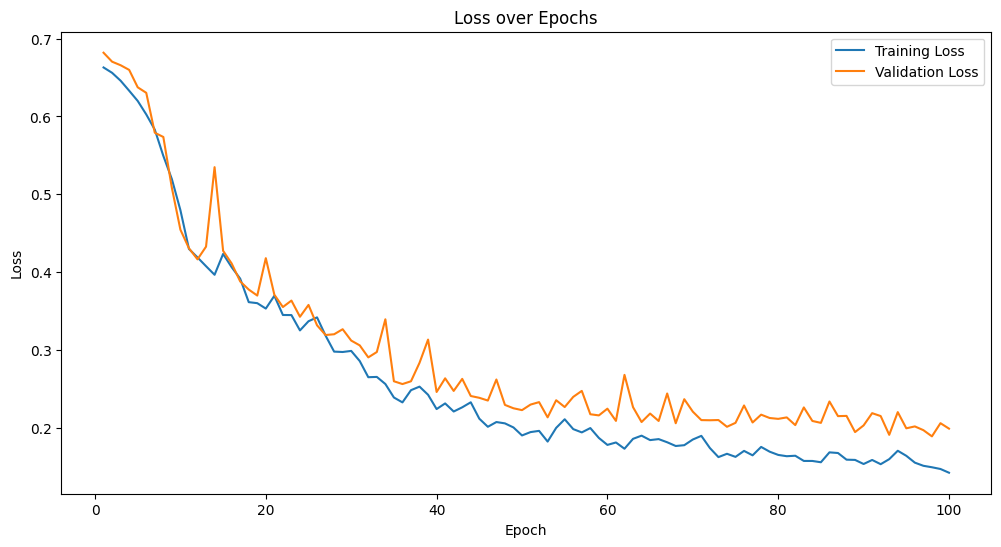

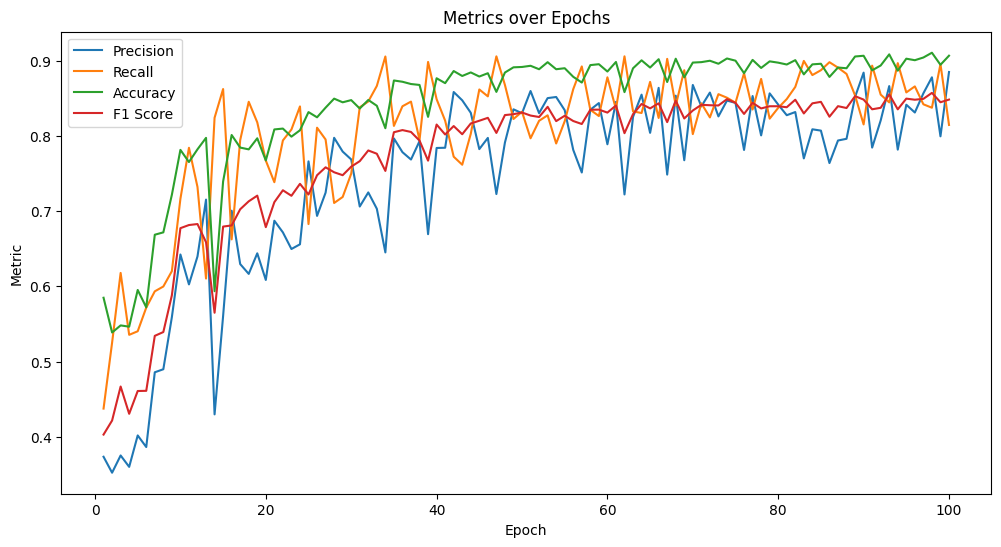

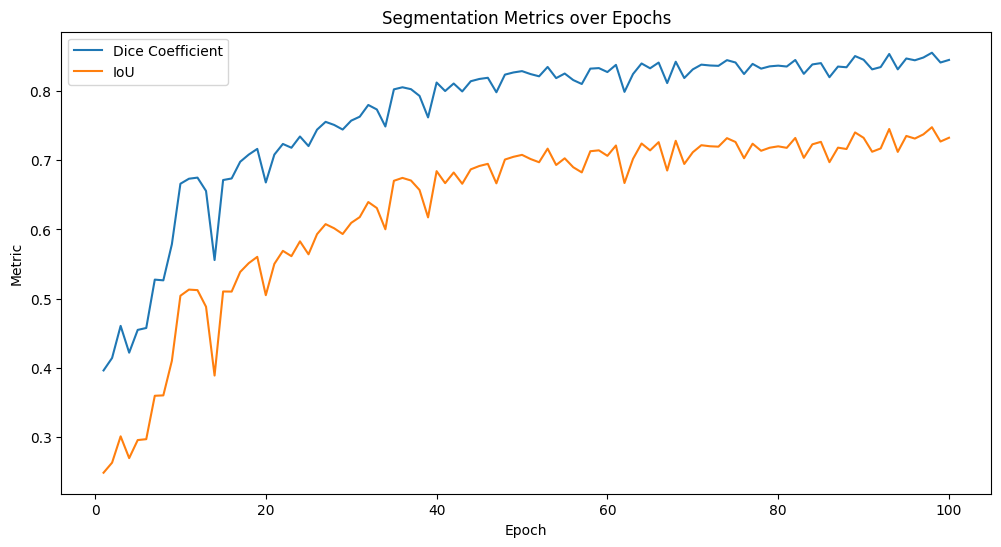

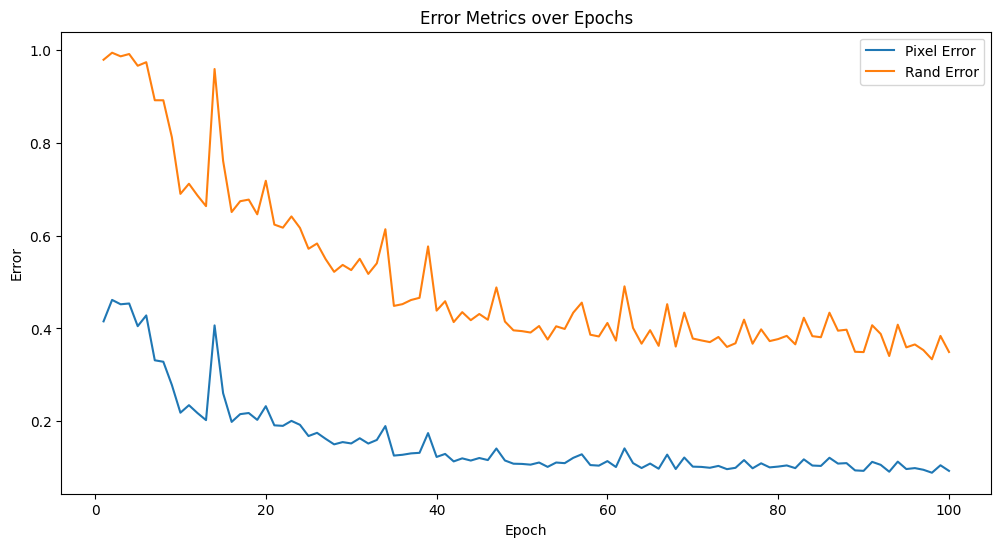

In [17]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.show()


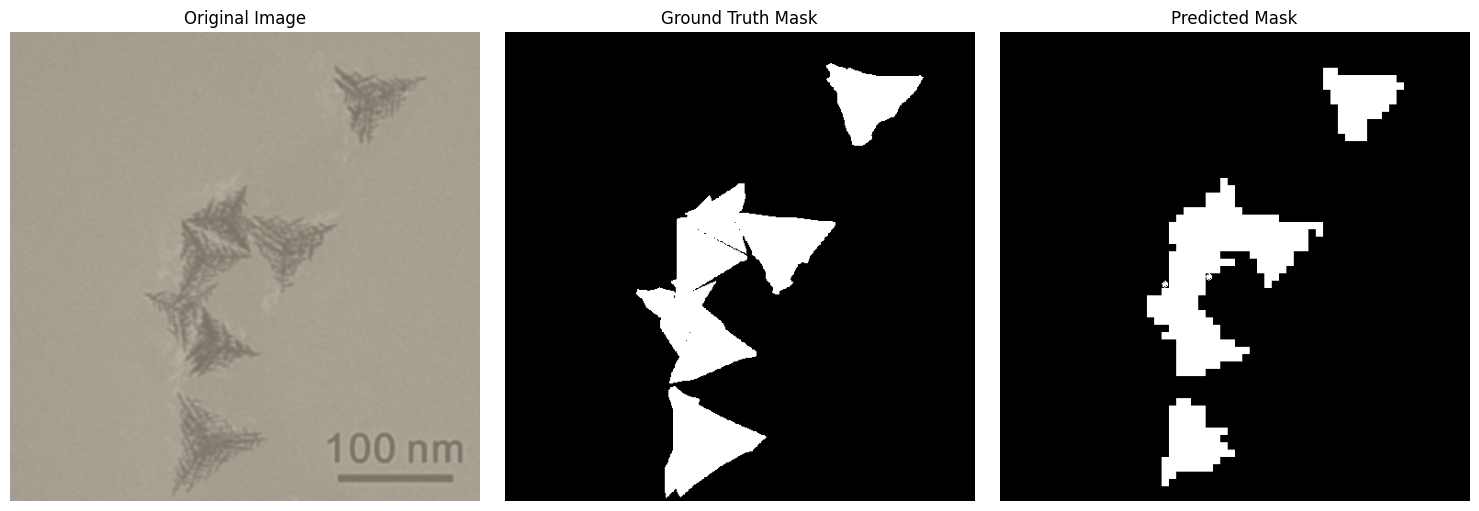

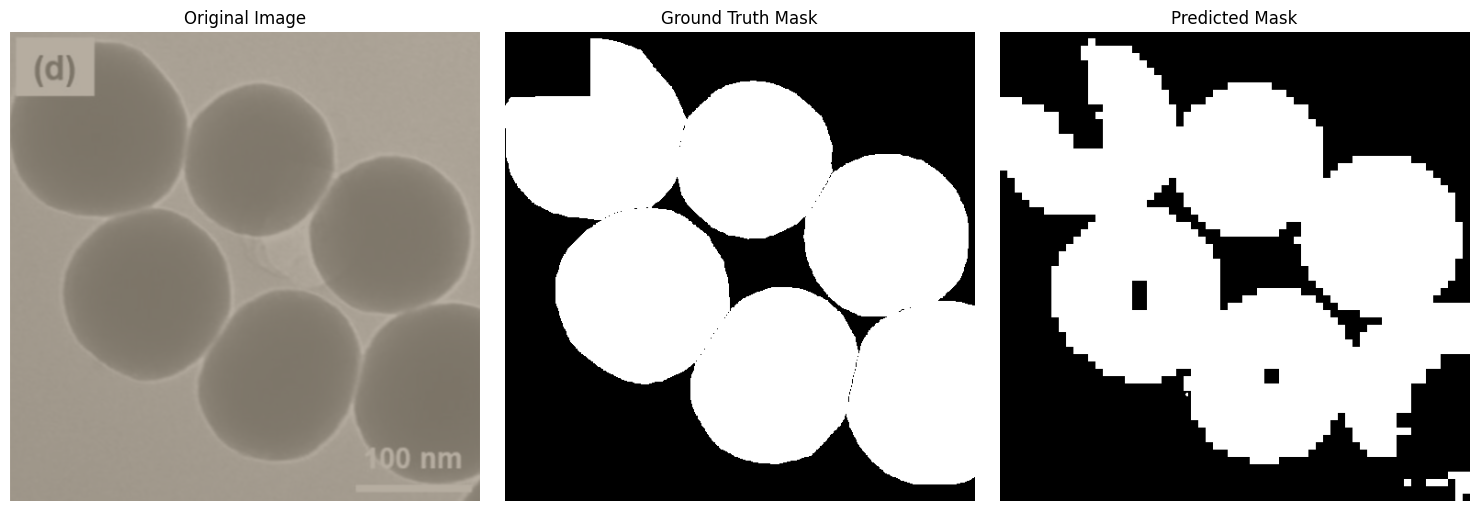

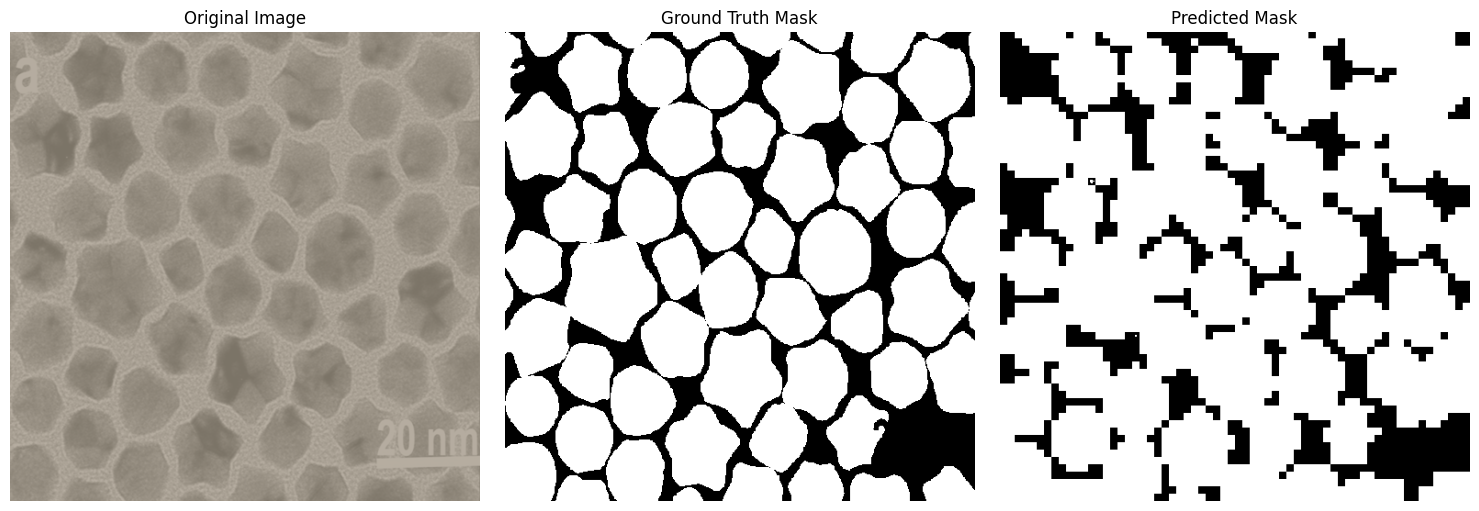

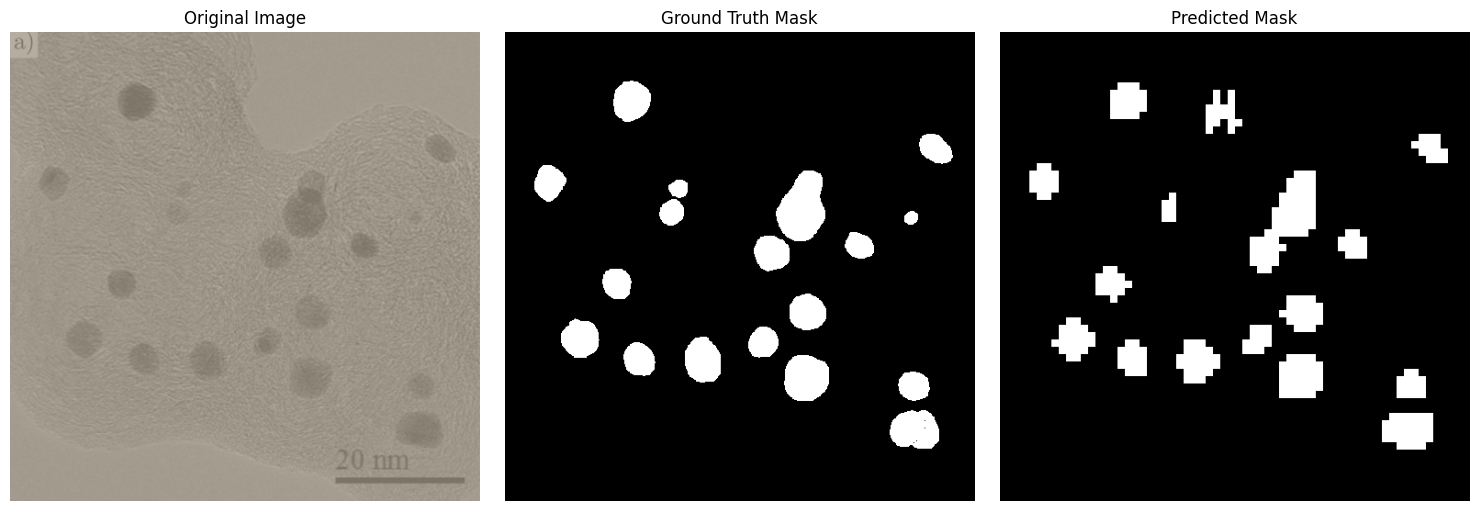

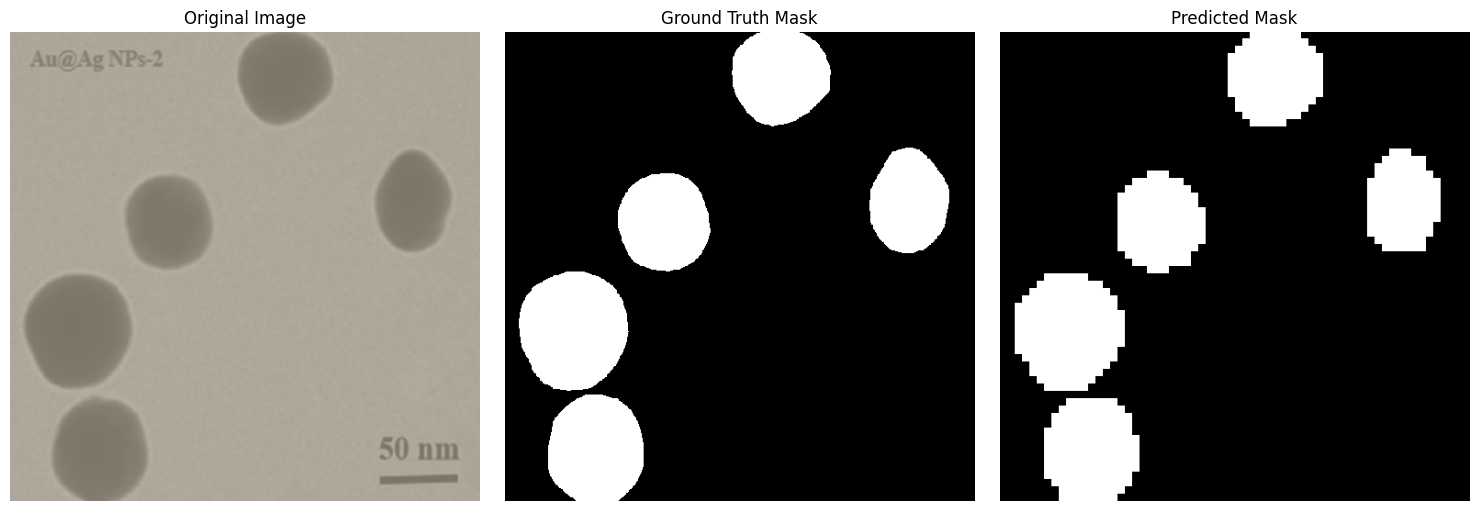

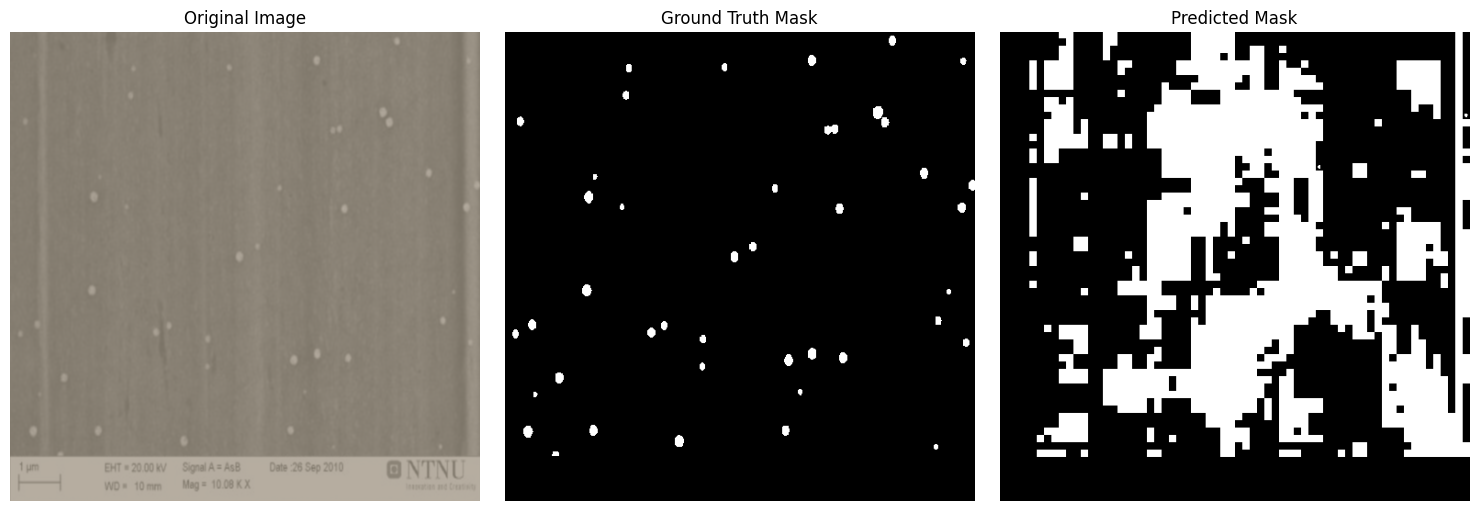

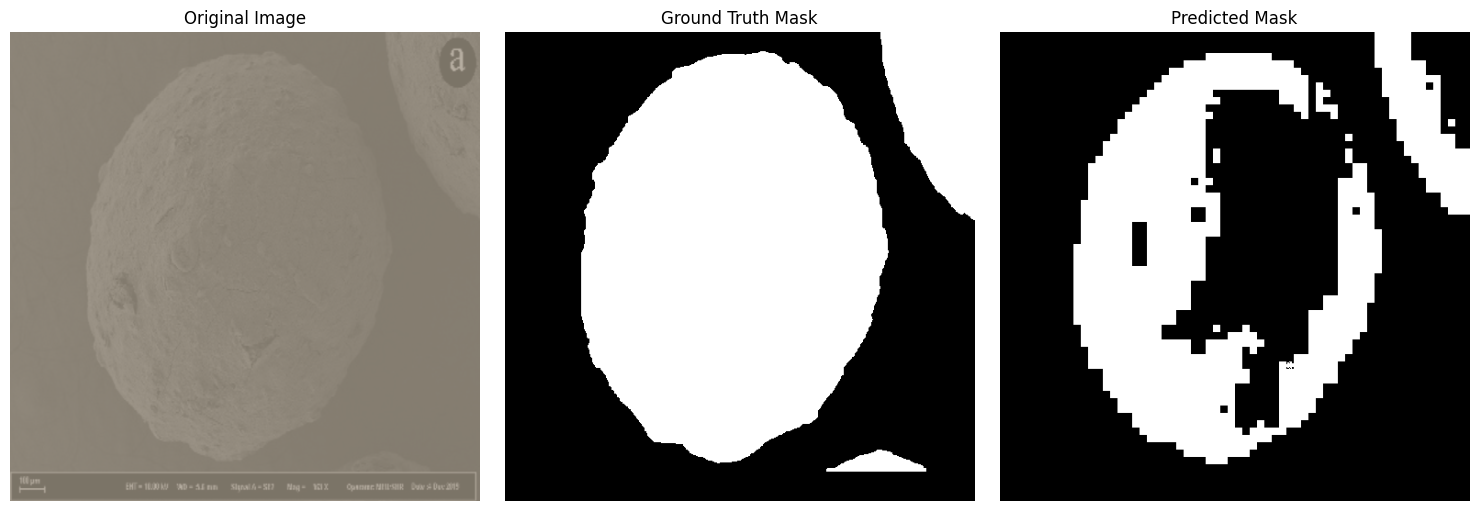

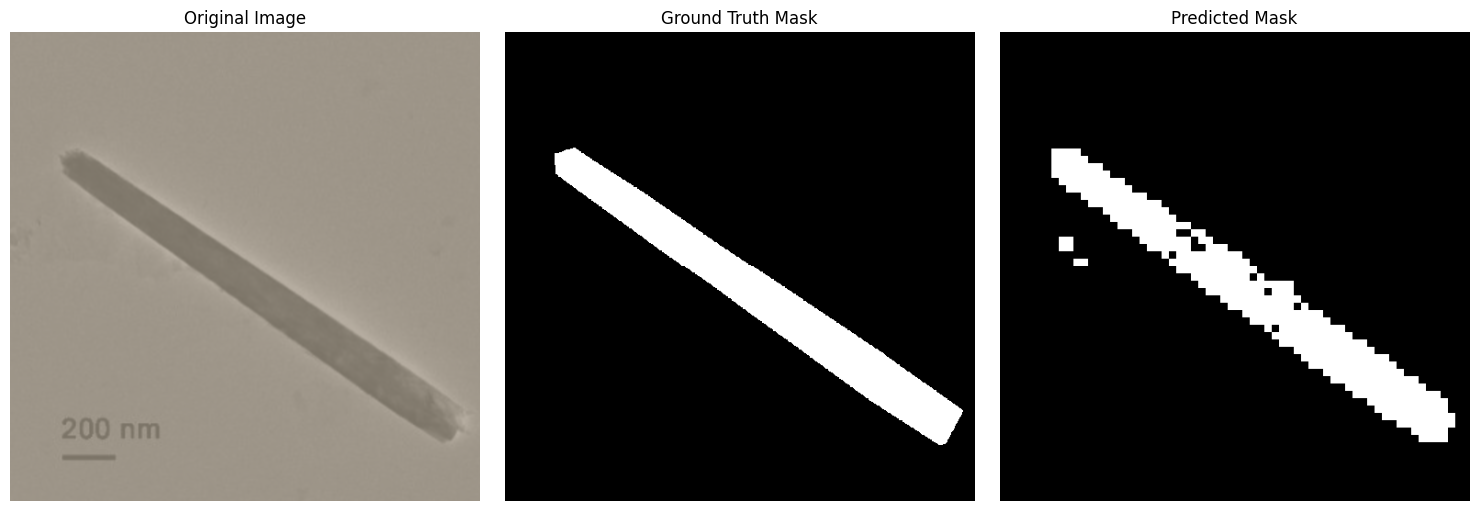

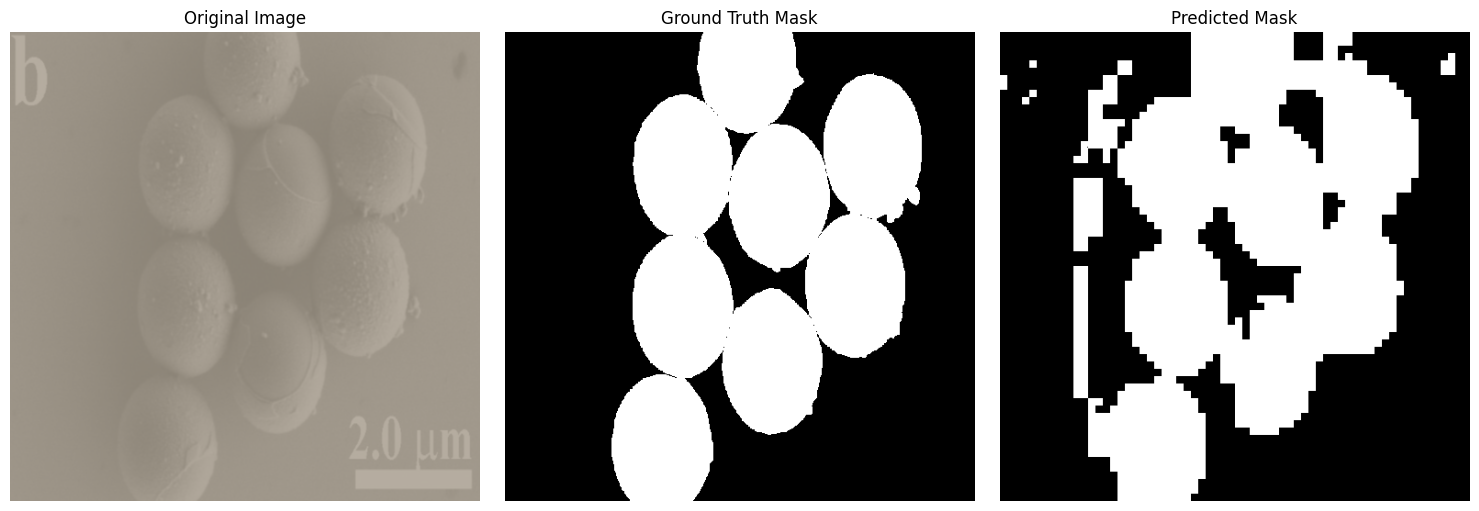

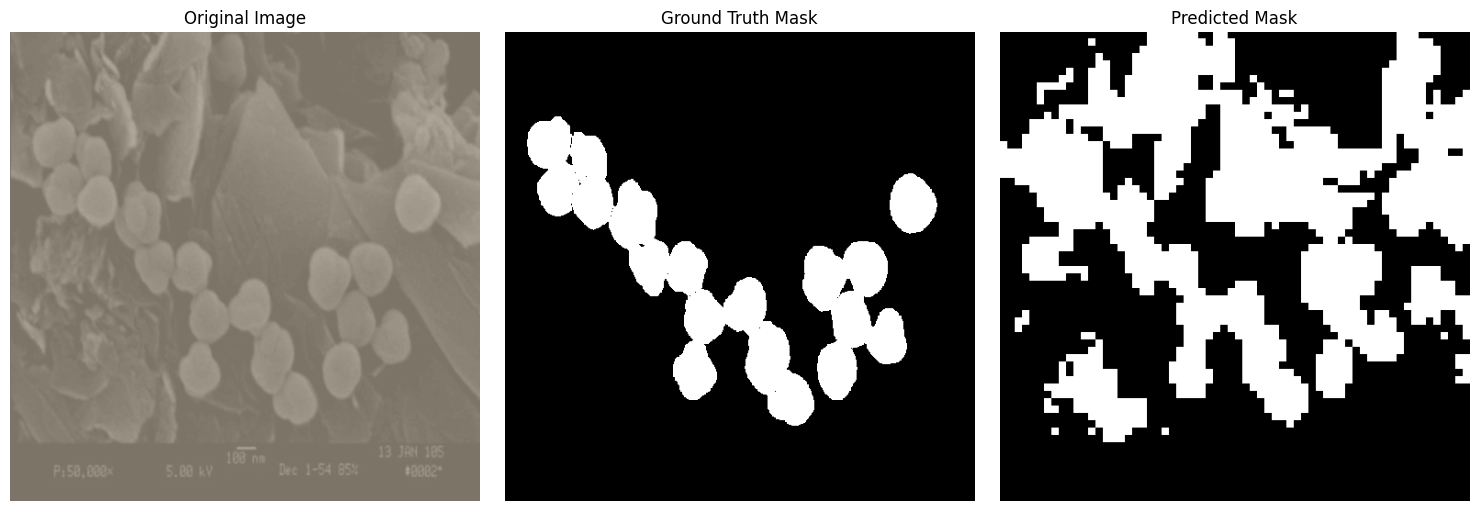

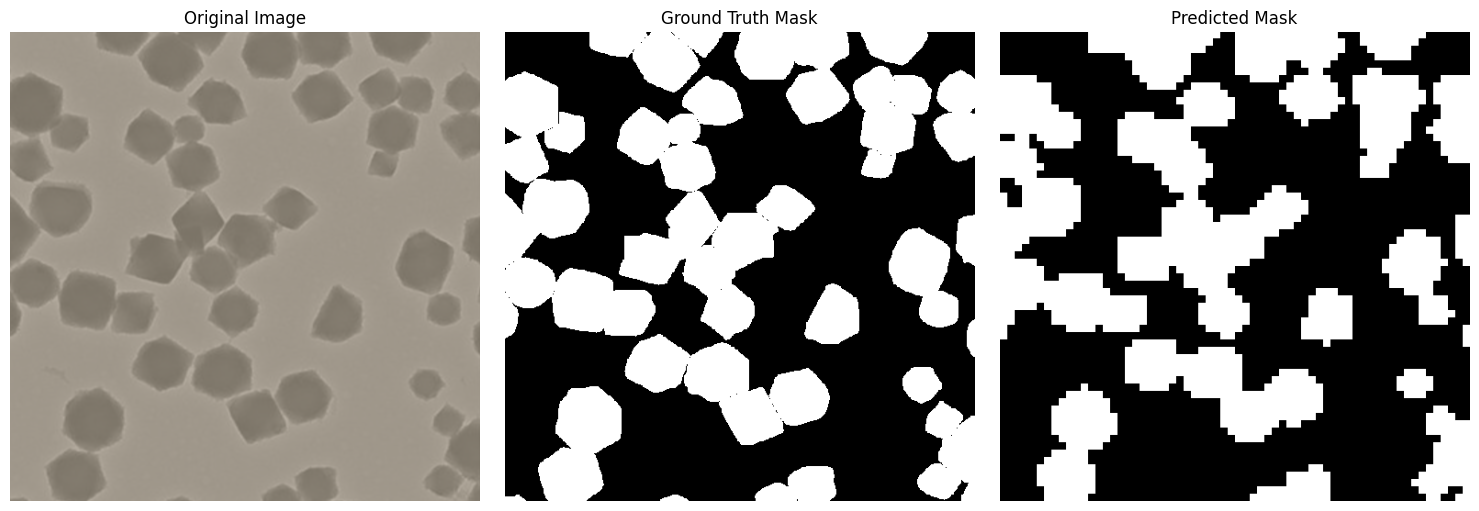

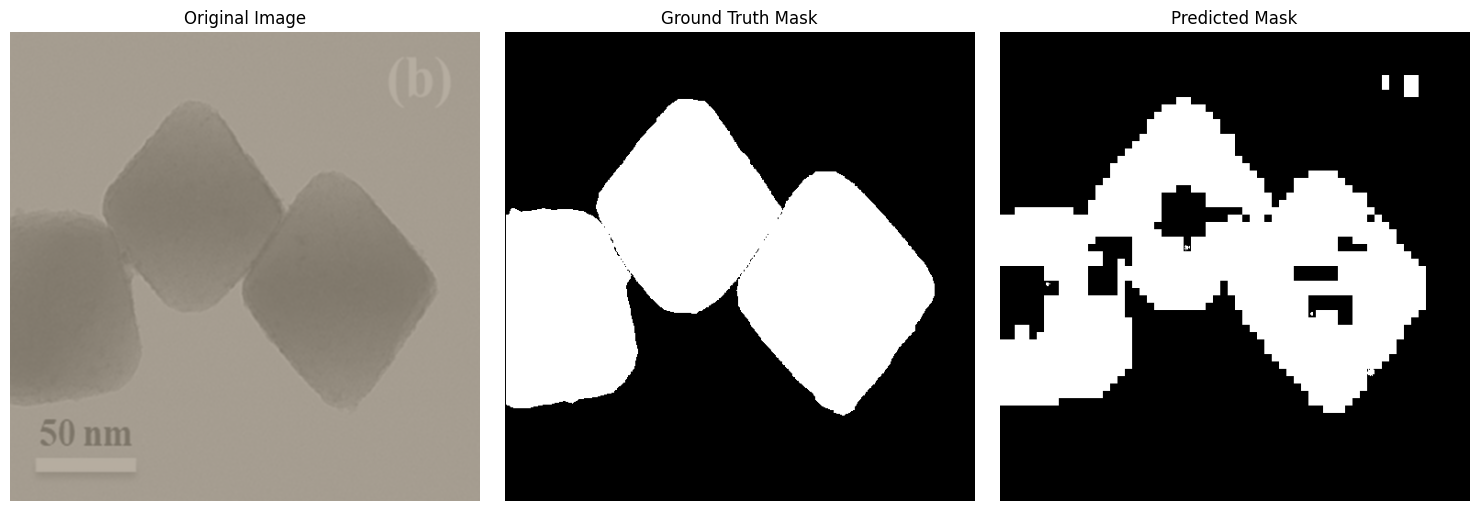

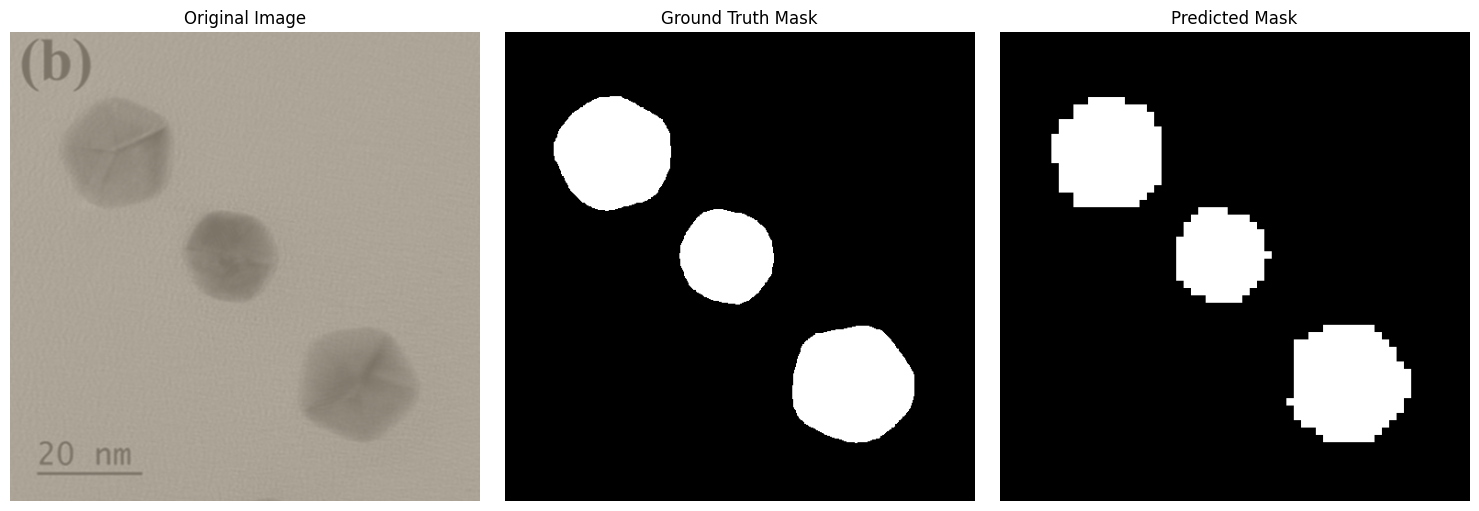

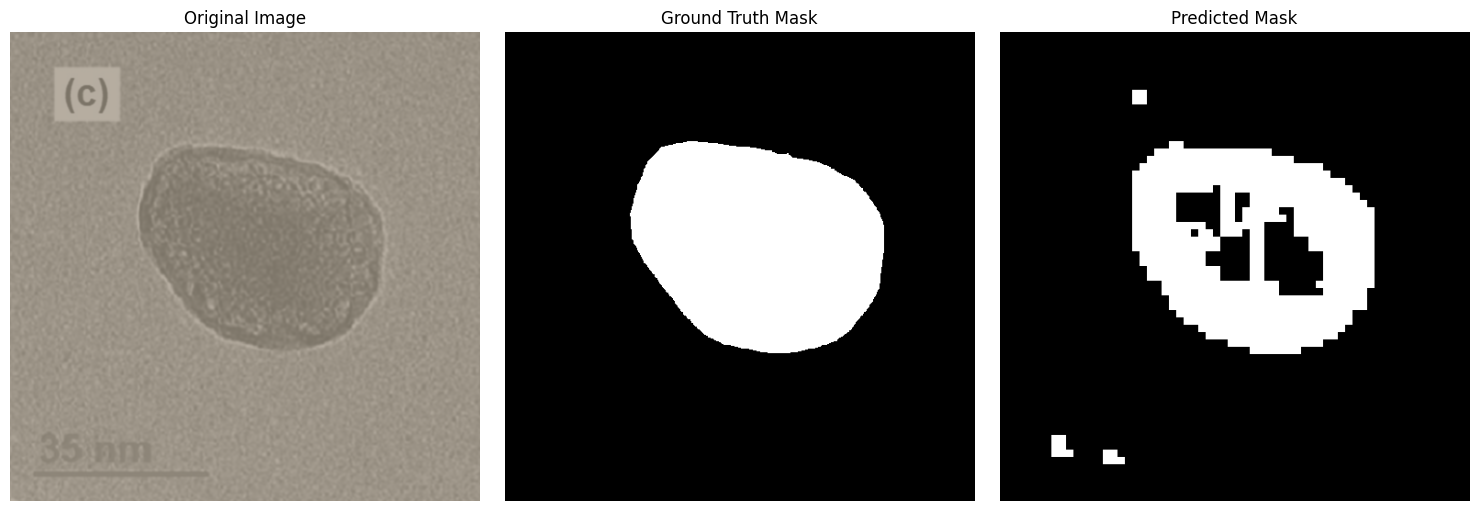

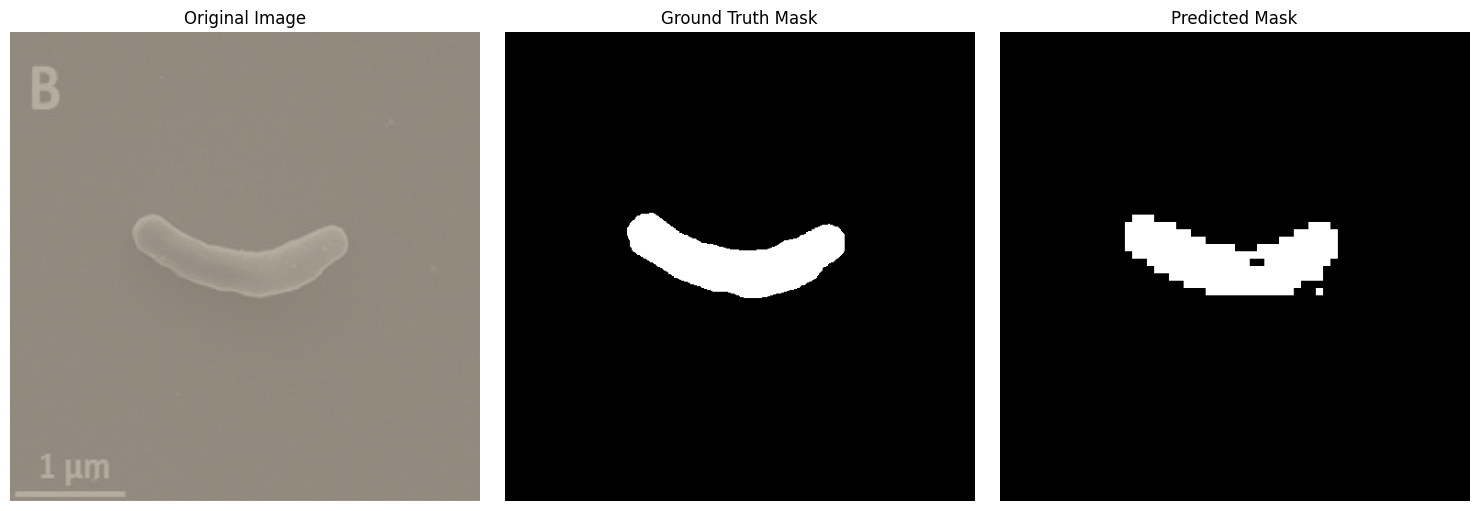

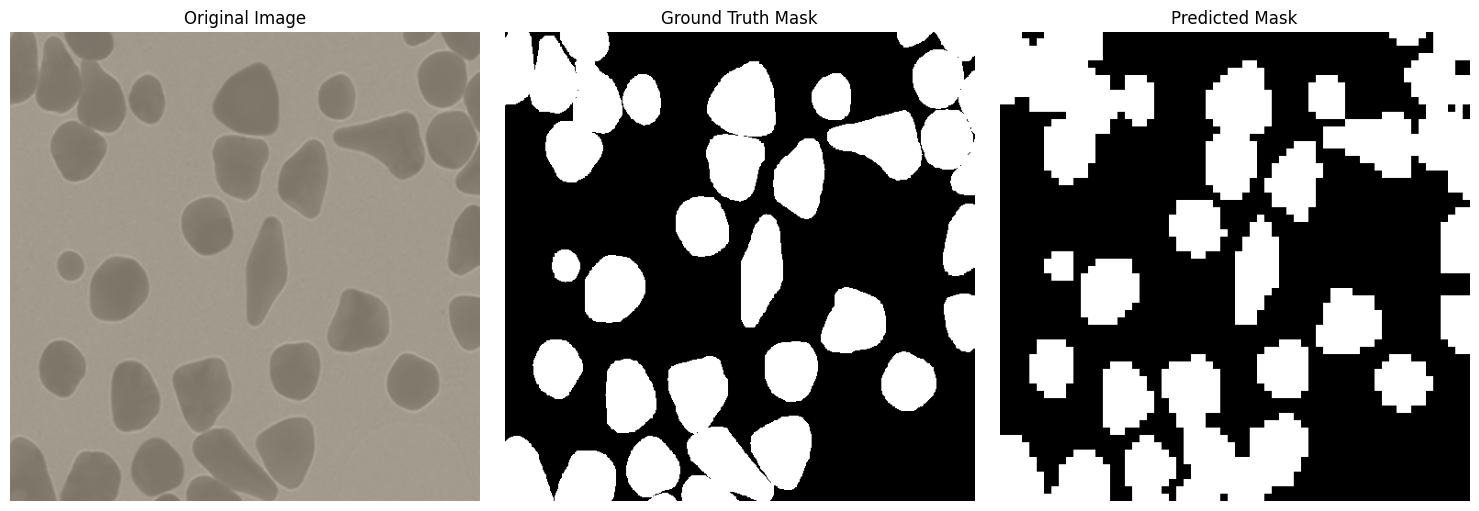

In [18]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    img = img * std + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()


In [30]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy       iou  \
0       1    0.662991  0.681930   0.373312  0.437383  0.584829  0.248520   
1       2    0.656113  0.670414   0.352070  0.525035  0.538618  0.263061   
2       3    0.645942  0.665842   0.375022  0.617837  0.548035  0.301087   
3       4    0.633112  0.659868   0.359859  0.535494  0.546344  0.269608   
4       5    0.619974  0.637504   0.401673  0.540264  0.595187  0.295699   
..    ...         ...       ...        ...       ...       ...       ...   
95     96    0.155261  0.201804   0.831257  0.865973  0.900816  0.731255   
96     97    0.151211  0.196995   0.856784  0.842171  0.904407  0.737311   
97     98    0.149334  0.189025   0.878070  0.837594  0.910773  0.747674   
98     99    0.147099  0.205951   0.799570  0.895676  0.894725  0.726955   
99    100    0.142309  0.198963   0.885113  0.814692  0.906823  0.732431   

          f1  dice_coeff  rand_error  pixel_error  
0   0.402815    0.396285    0.97855